In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1. Load data after pixel denoise and motion correction
see notebook `pixelNoise_motionCorrection_v1`

In [2]:
imgStack = np.load('tmpData/imgDMotion.npy')
Y = np.asarray(imgStack)
Y = Y.transpose([1,2,0])

## 2. Detrend raw signal on pixels

In [3]:
Y_detr = np.load('tmpData/Y_detr.npy')
trend = np.load('tmpData/Y_trend.npy')
mov = np.asarray(Y_detr,order='C',dtype=np.float64)
mov = (mov - mov.mean(axis=-1)[:, :, np.newaxis])/mov.std(axis=-1)[:, :, np.newaxis] #np.sqrt(mov.var(axis=-1)+1)[:, :, np.newaxis]

## 3 Spatial denoising using Tensorly

In [5]:
import tensorly as tl
from tensorly.decomposition import parafac
tl.set_backend('pytorch')
cp_rank = max(mov.shape[:-1]) * 2
pytorch_Yt_detr = tl.tensor(mov)

Using pytorch backend.


In [6]:
%%time
pytorch_factors = parafac(pytorch_Yt_detr, rank=cp_rank, init='random', tol=10e-6)

CPU times: user 1h 30min 16s, sys: 20min 35s, total: 1h 50min 51s
Wall time: 1h 50min 53s


In [7]:
cp_reconstruction = tl.kruskal_to_tensor(pytorch_factors)
Y_tensor = tl.to_numpy(cp_reconstruction)

## 3.1 Examining the denoise performance
### 3.1.1 Denoised images vs raw image

In [8]:
tmp_ = [mov, Y_tensor, mov-Y_tensor]
titles = ['Raw data', 'Tensor', 'Residual']
movie_ = ['Raw_data', 'Tensor', 'Residual']

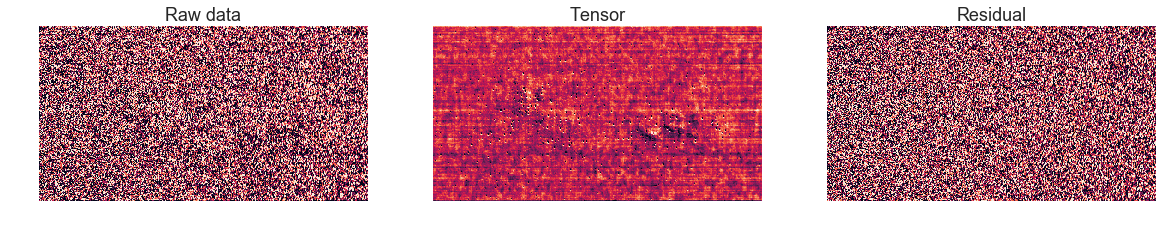

In [9]:
f, ax = plt.subplots(1, len(tmp_), figsize=(20, 5))
for nPlt in range(len(tmp_)):
    cf = ax[nPlt].imshow(tmp_[nPlt][:, :, 0], vmax = 1, vmin=-1)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

### 3.1.2 SNR

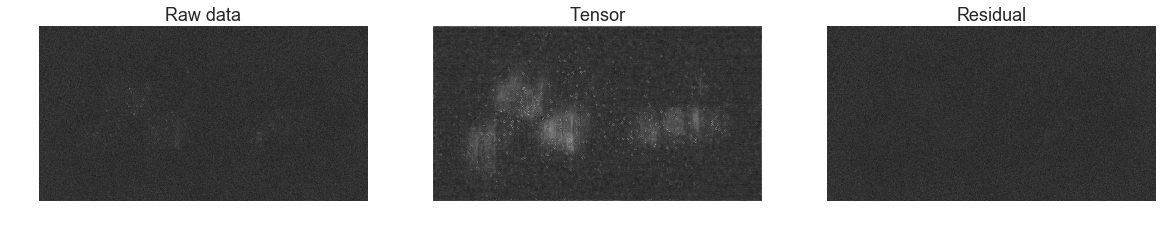

In [10]:
f, ax = plt.subplots(1, len(tmp_), figsize=(20, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    mean_ = Y_.mean(axis=2,keepdims=True)
    sn, psdx =cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_ - mean_,noise_method='logmexp')
    SNR_ = Y_.var(2)/sn**2
    cf = ax[nPlt].imshow(np.log(SNR_), vmin=0.1, vmax=2.5, cmap=plt.cm.gray)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

### 3.1.3 Local correlations

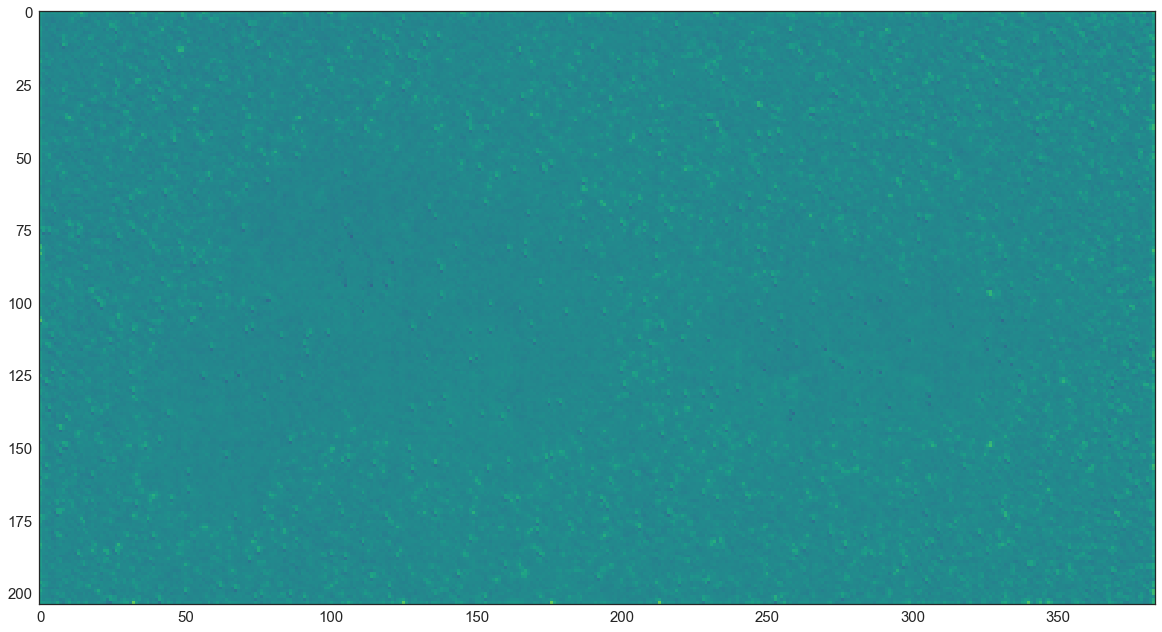

In [11]:
from trefide.extras.util_plot import correlation_pnr
Cn, _ = correlation_pnr(mov-Y_tensor, gSig=None, remove_small_val=False, remove_small_val_th=3, center_psf=False)
plt.figure(figsize=(20, 15))
plt.imshow(Cn, vmax=0.45, vmin=-0.1, cmap=plt.cm.viridis)
plt.show()

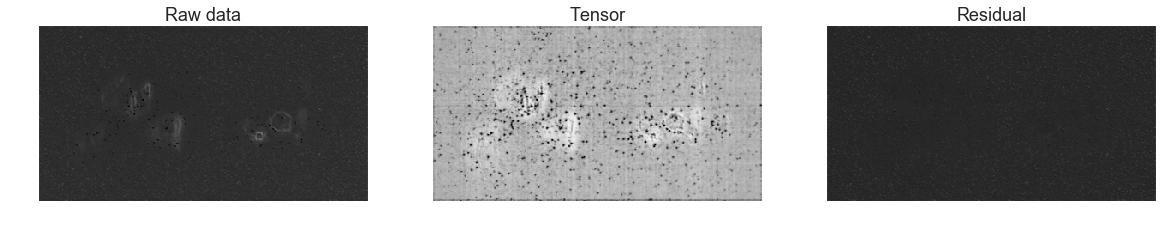

In [12]:
f, ax = plt.subplots(1, len(tmp_), figsize=(20, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    cf = ax[nPlt].imshow(cm.local_correlations(Y_), vmin=0, vmax=1, cmap=plt.cm.gray)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

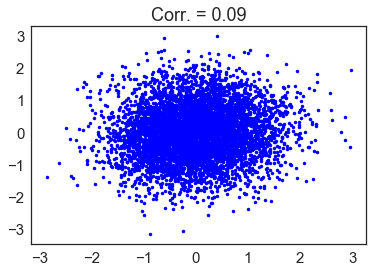

0.18550596


In [13]:
mov_r = mov-Y_tensor
loc = [131, 253]
plt.plot(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :], '.b')
plt.title('Corr. = %0.2f'%(np.corrcoef(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :])[0,1]))
plt.show()
print(Cn[loc[0], loc[1]])

## 3.2 Saving data

In [ ]:
# np.savez('tmpData/Y_denoised_svd', 
#          Y_amp = Y_detr.std(axis=-1)[:, :, np.newaxis], 
#          Y_ave = Y_detr.mean(axis=-1)[:, :, np.newaxis], 
#          Y_svd = Y_svd,
#          ranks = ranks,
#          ave_trend = trend.mean(axis=-1)[:, :, np.newaxis])